In [1]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab') # Add this line to download punkt_tab
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#for Bag of Words:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#for word2Vec embeddings:
!pip install gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
# Load dataset from your Google Drive path
file_path = '/content/drive/MyDrive/spam.csv'
df_sms = pd.read_csv(file_path, encoding='latin-1')

In [22]:
print(df_sms.head())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [4]:
# Basic Preprocessing: Lowercase, remove punctuation, tokenize, and remove stopwords
stop_words = set(stopwords.words('english'))

In [5]:
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

In [6]:
# Apply preprocessing
df_sms['cleaned_text'] = df_sms['v2'].apply(preprocess_text)

In [7]:
# Check the cleaned data
print(df_sms[['v2', 'cleaned_text']].head())

                                                  v2  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                        cleaned_text  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry 2 wkly comp win fa cup final tkts 2...  
3                u dun say early hor u c already say  
4        nah dont think goes usf lives around though  


In [8]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_sms['cleaned_text'], df_sms['v1'], test_size=0.2, random_state=42)

# BoW - Bag of Words
bow_vectorizer = CountVectorizer(min_df=3)  # min_df ensures we ignore words that appear too rarely
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [9]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(min_df=3)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [10]:
# Print the shapes of the feature matrices
print(f"BoW Training Set Shape: {X_train_bow.shape}")
print(f"TF-IDF Training Set Shape: {X_train_tfidf.shape}")

BoW Training Set Shape: (4457, 2244)
TF-IDF Training Set Shape: (4457, 2244)


In [11]:
# Tokenize the training and test data for Word2Vec
X_train_tokens = [text.split() for text in X_train]
X_test_tokens = [text.split() for text in X_test]

# Train Word2Vec model on the training data
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=3, sg=1, workers=4, epochs=10)

In [12]:
# Create document embeddings by averaging word vectors
def create_doc_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:  # If no word was found in the model, return a zero vector
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

In [13]:
X_train_w2v = np.array([create_doc_embedding(tokens, w2v_model) for tokens in X_train_tokens])
X_test_w2v = np.array([create_doc_embedding(tokens, w2v_model) for tokens in X_test_tokens])

In [14]:
# Print the shape of the document embeddings
print(f"Word2Vec Training Set Shape: {X_train_w2v.shape}")

Word2Vec Training Set Shape: (4457, 100)


In [16]:
#Logistic regression:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [17]:
# Convert target labels ('ham', 'spam') to binary (0, 1)
y_train_binary = (y_train == 'spam').astype(int)
y_test_binary = (y_test == 'spam').astype(int)

In [18]:
# Train a Logistic Regression model for BoW
lr_bow = LogisticRegression(max_iter=1000)
lr_bow.fit(X_train_bow, y_train_binary)
y_pred_bow = lr_bow.predict(X_test_bow)

In [19]:
# Train a Logistic Regression model for TF-IDF
lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train_binary)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)


In [20]:
# Train a Logistic Regression model for Word2Vec
lr_w2v = LogisticRegression(max_iter=1000)
lr_w2v.fit(X_train_w2v, y_train_binary)
y_pred_w2v = lr_w2v.predict(X_test_w2v)

In [21]:
# Evaluate the models
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, f1

In [22]:
# Evaluate all models
acc_bow, f1_bow = evaluate_model(y_test_binary, y_pred_bow)
acc_tfidf, f1_tfidf = evaluate_model(y_test_binary, y_pred_tfidf)
acc_w2v, f1_w2v = evaluate_model(y_test_binary, y_pred_w2v)

In [23]:
# Print the results
print(f"BoW Model - Accuracy: {acc_bow:.4f}, F1-Score: {f1_bow:.4f}")
print(f"TF-IDF Model - Accuracy: {acc_tfidf:.4f}, F1-Score: {f1_tfidf:.4f}")
print(f"Word2Vec Model - Accuracy: {acc_w2v:.4f}, F1-Score: {f1_w2v:.4f}")

BoW Model - Accuracy: 0.9776, F1-Score: 0.9091
TF-IDF Model - Accuracy: 0.9578, F1-Score: 0.8199
Word2Vec Model - Accuracy: 0.9578, F1-Score: 0.8327


In [25]:
#Visualisation
import matplotlib.pyplot as plt

In [26]:
# Comparison table
results = {
    'Model': ['BoW', 'TF-IDF', 'Word2Vec'],
    'Accuracy': [acc_bow, acc_tfidf, acc_w2v],
    'F1-Score': [f1_bow, f1_tfidf, f1_w2v]
}

results_df = pd.DataFrame(results)

# Print the results table
print(results_df)

      Model  Accuracy  F1-Score
0       BoW  0.977578  0.909091
1    TF-IDF  0.957848  0.819923
2  Word2Vec  0.957848  0.832740


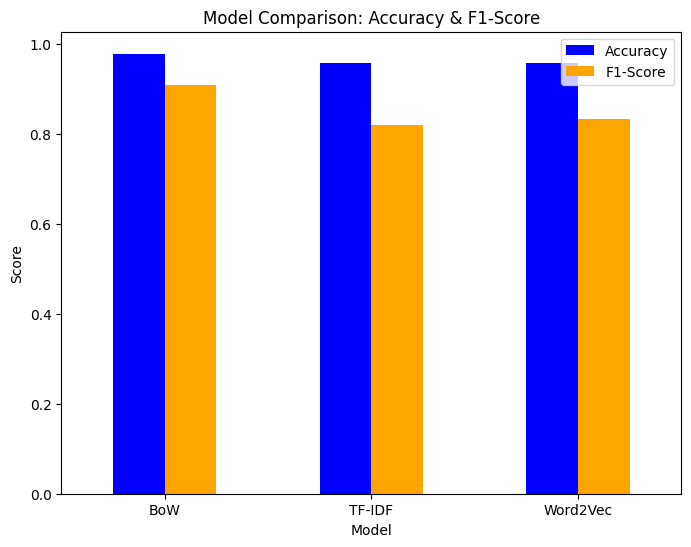

In [27]:
# Visualize the performance comparison
results_df.set_index('Model').plot(kind='bar', figsize=(8, 6), color=['blue', 'orange'])
plt.title('Model Comparison: Accuracy & F1-Score')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.show()

In [29]:
#GloVe embeddings:
import gensim.downloader as api

In [30]:
# Load pre-trained GloVe embeddings (100-dimensional)
glove_model = api.load('glove-wiki-gigaword-100')  # ~100MB download (first-time use)

# Create document embeddings using GloVe (mean of word embeddings in each document)
def create_glove_embedding(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if len(vectors) == 0:  # If no word was found in the model, return a zero vector
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

[==================================================] 100.0% 128.1/128.1MB downloaded


In [31]:
X_train_glove = np.array([create_glove_embedding(tokens, glove_model) for tokens in X_train_tokens])
X_test_glove = np.array([create_glove_embedding(tokens, glove_model) for tokens in X_test_tokens])

# Print the shape of the GloVe document embeddings
print(f"GloVe Training Set Shape: {X_train_glove.shape}")

GloVe Training Set Shape: (4457, 100)


In [32]:
#FastText Embeddings:
from gensim.models import FastText

In [33]:
# Train FastText model on the training data
ft_model = FastText(sentences=X_train_tokens, vector_size=100, window=5, min_count=3, workers=4, epochs=10)

# Create document embeddings using FastText (mean of word embeddings in each document)
def create_fasttext_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:  # If no word was found in the model, return a zero vector
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

In [34]:
X_train_ft = np.array([create_fasttext_embedding(tokens, ft_model) for tokens in X_train_tokens])
X_test_ft = np.array([create_fasttext_embedding(tokens, ft_model) for tokens in X_test_tokens])

# Print the shape of the FastText document embeddings
print(f"FastText Training Set Shape: {X_train_ft.shape}")

FastText Training Set Shape: (4457, 100)


In [35]:
# Train Logistic Regression for GloVe
lr_glove = LogisticRegression(max_iter=1000)
lr_glove.fit(X_train_glove, y_train_binary)
y_pred_glove = lr_glove.predict(X_test_glove)

# Train Logistic Regression for FastText
lr_ft = LogisticRegression(max_iter=1000)
lr_ft.fit(X_train_ft, y_train_binary)
y_pred_ft = lr_ft.predict(X_test_ft)

In [36]:
# Evaluate GloVe and FastText models
acc_glove, f1_glove = evaluate_model(y_test_binary, y_pred_glove)
acc_ft, f1_ft = evaluate_model(y_test_binary, y_pred_ft)

# Print results
print(f"GloVe Model - Accuracy: {acc_glove:.4f}, F1-Score: {f1_glove:.4f}")
print(f"FastText Model - Accuracy: {acc_ft:.4f}, F1-Score: {f1_ft:.4f}")

GloVe Model - Accuracy: 0.9345, F1-Score: 0.7420
FastText Model - Accuracy: 0.9058, F1-Score: 0.5070


In [37]:
# Update the results table
results = {
    'Model': ['BoW', 'TF-IDF', 'Word2Vec', 'GloVe', 'FastText'],
    'Accuracy': [acc_bow, acc_tfidf, acc_w2v, acc_glove, acc_ft],
    'F1-Score': [f1_bow, f1_tfidf, f1_w2v, f1_glove, f1_ft]
}

results_df = pd.DataFrame(results)

# Print the updated results table
print(results_df)

      Model  Accuracy  F1-Score
0       BoW  0.977578  0.909091
1    TF-IDF  0.957848  0.819923
2  Word2Vec  0.957848  0.832740
3     GloVe  0.934529  0.742049
4  FastText  0.905830  0.507042


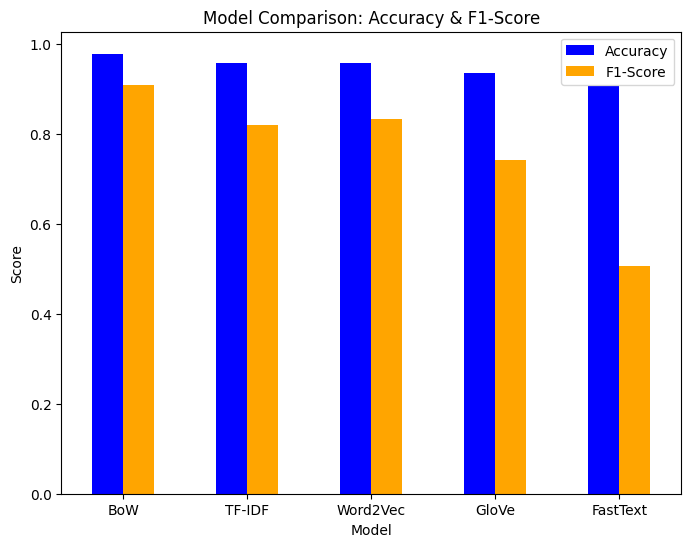

In [38]:
# Visualize the performance comparison
results_df.set_index('Model').plot(kind='bar', figsize=(8, 6), color=['blue', 'orange'])
plt.title('Model Comparison: Accuracy & F1-Score')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.show()

Updated results saved to embedding_results_updated.csv
Updated bar chart saved as model_comparison_bar_chart_updated.png


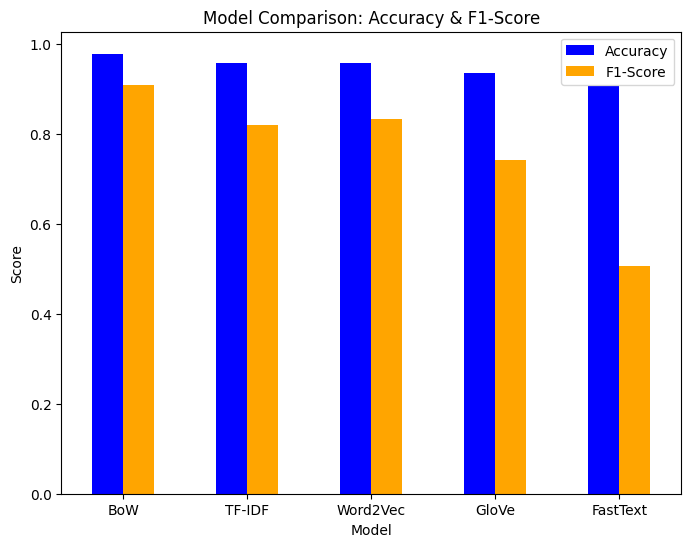

In [39]:
#Reporting Purpose:
# Save the updated comparison results to a CSV file
results_df.to_csv('/content/embedding_results_updated.csv', index=False)
print("Updated results saved to embedding_results_updated.csv")

# Save the updated bar chart as an image
results_df.set_index('Model').plot(kind='bar', figsize=(8, 6), color=['blue', 'orange'])
plt.title('Model Comparison: Accuracy & F1-Score')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.savefig('/content/model_comparison_bar_chart_updated.png', bbox_inches='tight')
print("Updated bar chart saved as model_comparison_bar_chart_updated.png")